In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import matplotlib.pyplot as plt

print('Imported.')

Imported.


In [2]:
pip install lxml html5lib beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'V1JP0OQNXOSW0TMHAKMEP33U1UAWHCO2I3LZQLTI1MEA1D2Y' # your Foursquare ID
CLIENT_SECRET = 'Y2YU3WT2HRVMRR5H2RPXM3BOW5XMYDN3EIAO2A0MMHW0SEDN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [4]:
#Download Bangkok, Thailand list of Districts 
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
dfs = pd.read_html(url)
print(dfs[0])

          District(Khet)  MapNr  Post-code               Thai  Popu-lation  \
0               Bang Bon     50      10150             บางบอน       105161   
1              Bang Kapi      6      10240            บางกะปิ       148465   
2              Bang Khae     40      10160              บางแค       191781   
3              Bang Khen      5      10220             บางเขน       189539   
4          Bang Kho Laem     31      10120          บางคอแหลม        94956   
5        Bang Khun Thian     21      10150        บางขุนเทียน       165491   
6                Bang Na     47      10260              บางนา        95912   
7             Bang Phlat     25      10700            บางพลัด        99273   
8               Bang Rak      4      10500             บางรัก        45875   
9               Bang Sue     29      10800            บางซื่อ       132234   
10           Bangkok Noi     20      10700         บางกอกน้อย       117793   
11           Bangkok Yai     16      10600         บางกอกใหญ่   

In [5]:
#Transform to Dataframe
df = dfs[0]

In [6]:
#Fix spelling of the columns
df = df.rename(columns={"Popu-lation": "Population"})
df = df.rename(columns={"District(Khet)": "District"})
df = df.rename(columns={"Post-code": "Postcode"})

In [7]:
#Clean table 
BKK_districts = df[['District','Postcode','Population','Latitude', 'Longitude']]

In [8]:
#check if everything is ok
BKK_districts.head()

,District,Postcode,Population,Latitude,Longitude
0,Bang Bon,10150,105161,13.659200,100.399100
1,Bang Kapi,10240,148465,13.765833,100.647778
2,Bang Khae,10160,191781,13.696111,100.409444
3,Bang Khen,10220,189539,13.873889,100.596389
4,Bang Kho Laem,10120,94956,13.693333,100.502500


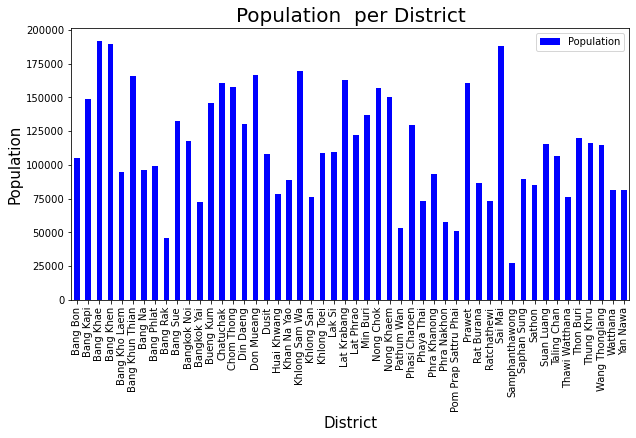

In [9]:
#create an istrogram 
clr = "blue"
BKK_districts.groupby('District')['Population'].sum().plot.bar(figsize=(10,5), color=clr)
plt.title('Population  per District', fontsize = 20)
plt.xlabel('District', fontsize = 15)
plt.ylabel('Population',fontsize = 15)
plt.legend()
plt.show()

In [10]:
#extract the first district to be use in a test 
df.loc[0, 'District']

'Bang Bon'

In [11]:
#test if you can extract Lat and Long
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bang Bon are 13.6592, 100.3991.


In [12]:
#extract the data from Foursquare 
LIMIT = 500

radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=V1JP0OQNXOSW0TMHAKMEP33U1UAWHCO2I3LZQLTI1MEA1D2Y&client_secret=Y2YU3WT2HRVMRR5H2RPXM3BOW5XMYDN3EIAO2A0MMHW0SEDN&v=20180605&ll=13.6592,100.3991&radius=1000&limit=500'

In [13]:
#define the main functions used later

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=1000
    LIMIT=500
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
# prepare neighborhood list that contains Italian restaurants

column_names=['District', 'ID','Name']
ita_rest_bkk=pd.DataFrame(columns=column_names)
count=1
for row in BKK_districts.values.tolist():
    District, Postcode, Population, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(BKK_districts),')','Italian Restaurant in '+District+':'+str(len(italian_restaurants)))
    print(row)
    for resturant_detail in italian_restaurants.values.tolist():
        id, name , category=resturant_detail
        ita_rest_bkk = ita_rest_bkk.append({'District': District,
                                                 'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 50 ) Italian Restaurant in Bang Bon:0
['Bang Bon', 10150, 105161, 13.6592, 100.3991]
( 2 / 50 ) Italian Restaurant in Bang Kapi:0
['Bang Kapi', 10240, 148465, 13.765832999999999, 100.647778]
( 3 / 50 ) Italian Restaurant in Bang Khae:0
['Bang Khae', 10160, 191781, 13.696110999999998, 100.409444]
( 4 / 50 ) Italian Restaurant in Bang Khen:0
['Bang Khen', 10220, 189539, 13.873889000000002, 100.596389]
( 5 / 50 ) Italian Restaurant in Bang Kho Laem:1
['Bang Kho Laem', 10120, 94956, 13.693332999999999, 100.5025]
( 6 / 50 ) Italian Restaurant in Bang Khun Thian:0
['Bang Khun Thian', 10150, 165491, 13.660832999999998, 100.435833]
( 7 / 50 ) Italian Restaurant in Bang Na:0
['Bang Na', 10260, 95912, 13.680081, 100.5918]
( 8 / 50 ) Italian Restaurant in Bang Phlat:0
['Bang Phlat', 10700, 99273, 13.793889000000002, 100.505]
( 9 / 50 ) Italian Restaurant in Bang Rak:0
['Bang Rak', 10500, 45875, 13.730832999999999, 100.524167]
( 10 / 50 ) Italian Restaurant in Bang Sue:0
['Bang Sue', 10800, 

In [15]:
#make a back-up in .csv file 
ita_rest_bkk.to_csv('ita_rest_bkk_tocsv1.csv')

In [16]:
#check data
ita_bkk = pd.read_csv('ita_rest_bkk_tocsv1.csv')
ita_rest_bkk.tail()

,District,ID,Name
12,Ratchathewi,4b46b7f7f964a520542726e3,Primavera
13,Samphanthawong,4e3a8d61a809ec55443c9e3c,Viva & Aviv The River
14,Suan Luang,536f66ca498e4c73691a56b9,Sireena Italian Restaurant
15,Watthana,4f76e9cbe4b0e91fa6623296,Sole Mio
16,Watthana,526cc2c6498ea29948f9ce08,50/50 Restaurant & Bar


In [17]:
#check the data size
ita_rest_bkk.shape

(17, 3)

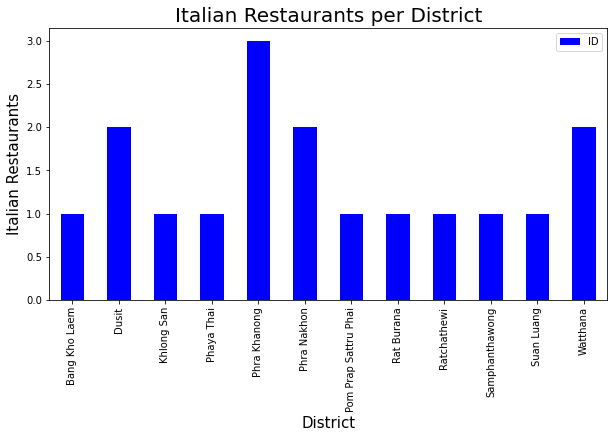

In [18]:
#Let's Visualize the distribution of the Italian Restaurants
ita_rest_bkk.groupby('District')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per District', fontsize = 20)
plt.xlabel('District', fontsize = 15)
plt.ylabel('Italian Restaurants',fontsize = 15)
plt.legend()
plt.show()

In [19]:
column_names=['District', 'ID','Name','Likes','Rating','Tips']
ita_rest_stats_bkk=pd.DataFrame(columns=column_names)
count=1
for row in ita_rest_bkk.values.tolist():
    Disrict, ID, Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ita_rest_bkk),')','processed')
    ita_rest_stats_bkk = ita_rest_stats_bkk.append({'Disrict': Disrict,
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
ita_rest_stats_bkk.head()

{'meta': {'code': 200, 'requestId': '5fcc991be74939020358950b'}, 'response': {'venue': {'id': '4db5437b0cb6729b6aa17a41', 'name': 'Harbour View', 'contact': {}, 'location': {'address': 'Montien Riverside Hotel', 'lat': 13.687815606440395, 'lng': 100.50808363694624, 'labeledLatLngs': [{'label': 'display', 'lat': 13.687815606440395, 'lng': 100.50808363694624}], 'cc': 'TH', 'city': 'บางโคล่', 'state': 'กรุงเทพมหานคร', 'country': 'ประเทศไทย', 'formattedAddress': ['Montien Riverside Hotel', 'บางโคล่', 'กรุงเทพมหานคร', 'ประเทศไทย']}, 'canonicalUrl': 'https://foursquare.com/v/harbour-view/4db5437b0cb6729b6aa17a41', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '฿'}, 'likes': {'count': 0, 

KeyError: 'venue'

In [20]:
#make a back-up in .csv file 
ita_rest_stats_bkk.to_csv('ita_rest_stats_bkk_csv.csv')

In [21]:
#check the data format
ita_rest_stats_bkk.shape

(10, 7)

In [22]:
#trasform data format
ita_rest_stats_bkk['Likes'] = ita_rest_stats_bkk['Likes'].astype('float64')
ita_rest_stats_bkk['Tips'] = ita_rest_stats_bkk['Tips'].astype('float64')
ita_rest_stats_bkk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   District  0 non-null      float64
 1   ID        10 non-null     object 
 2   Name      10 non-null     object 
 3   Likes     10 non-null     float64
 4   Rating    10 non-null     object 
 5   Tips      10 non-null     float64
 6   Disrict   10 non-null     object 
dtypes: float64(3), object(4)
memory usage: 688.0+ bytes


In [23]:
# Resturant with maximum Likes
ita_rest_stats_bkk.iloc[ita_rest_stats_bkk['Likes'].idxmax()]

District                         NaN
ID          4e3a8d61a809ec55443c9e3c
Name           Viva & Aviv The River
Likes                             89
Rating                           7.6
Tips                              37
Disrict                   Khlong San
Name: 3, dtype: object

In [30]:
# Resturant with maximum Ratings
ita_rest_stats_bkk.iloc[ita_rest_stats_bkk['Rating'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [ ]:
#create a table groupping the district 
BKK_districts_stats=ita_rest_stats_bkk.groupby('Disrict',as_index=False).mean()[['Disrict','Rating']]
BKK_districts_stats.columns=['District','Average Rating']
BKK_districts_stats.sort_values(['Average Rating'],ascending=False).head(50)

In [27]:
#create a table groupping the district 
BKK_districts_stats_L=ita_rest_stats_bkk.groupby('Disrict',as_index=False).mean()[['Disrict','Likes']]
BKK_districts_stats_L.columns=['District','Average Likes']
BKK_districts_stats_L.sort_values(['Average Likes'],ascending=False).head(50)

,District,Average Likes
2,Khlong San,89.000000
4,Phra Khanong,30.333333
3,Phaya Thai,27.000000
5,Phra Nakhon,18.500000
1,Dusit,16.000000
0,Bang Kho Laem,0.000000


In [28]:
#Let's Visualize the distribution of the Rating
BKK_districts_stats.groupby('District')['Average Rating'].mean().plot.bar(figsize=(10,5), color=clr)
plt.title('Average Rating per District', fontsize = 20)
plt.xlabel('District', fontsize = 15)
plt.ylabel('Average Rating',fontsize = 15)
plt.legend()
plt.show()


NameError: name 'BKK_districts_stats' is not defined

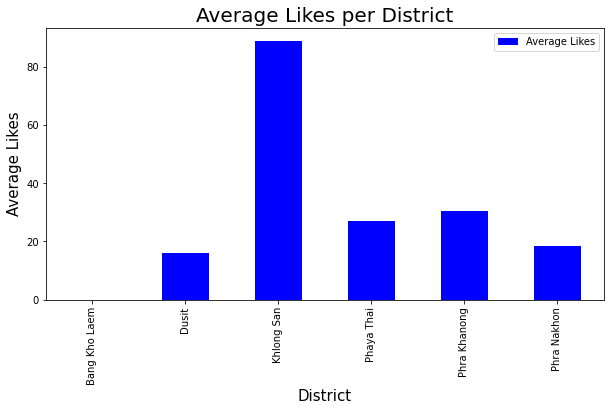

In [29]:
#Let's Visualize the distribution of the Likes
BKK_districts_stats_L.groupby('District')['Average Likes'].mean().plot.bar(figsize=(10,5), color=clr)
plt.title('Average Likes per District', fontsize = 20)
plt.xlabel('District', fontsize = 15)
plt.ylabel('Average Likes',fontsize = 15)
plt.legend()
plt.show()
